## HTCondor DAGman Wavefront application

This notebook is intended to demonstrate the usage of DAGman for a simplified wavefront example.

In [15]:
# Main library imports
import numpy as np
import htcondor

# Used for plotting
import plotly.offline as py
import plotly.graph_objects as go
py.init_notebook_mode(connected=False)

HTCondor comprises two basic concepts [HTCondor intro]:

* The **Collector** maintains an inventory of all the pieces of the HTCondor pool. For example, each machine that can run jobs will advertise a ClassAd describing its resources and state. In this module, we'll learn the basics of querying the collector for information and displaying results.
* The **Schedd** maintains a queue of jobs and is responsible for managing their execution. We'll learn the basics of querying the schedd.

In [6]:
n_gridpoints = 10

# set seed for reproducability
rand=np.random.RandomState(seed=1)
grid = rand.uniform(size=(n_gridpoints, n_gridpoints))
grid_transitions = rand.uniform(size=(n_gridpoints-1, n_gridpoints-1, 3))

# copy grid to grid_serial which is used to calculate the serial version
grid_serial = grid.copy()

# normalize transition probabilities to 1
summed = np.reshape(np.sum(grid_transitions, 2), (n_gridpoints-1, n_gridpoints-1, 1))
grid_transitions = grid_transitions / np.tile(summed, (1,1, 3))

In [12]:
n_blocks=3
local_gridpoints = (n_gridpoints - 1) // n_blocks 
for i in range(3):
    for j in range(3):
        np.save("grid_transitions_"+str(j+1) + str(i+1), 
                   grid_transitions[((i)*(local_gridpoints)):((i+1)*(local_gridpoints)), 
                                    ((j)*(local_gridpoints)):((j+1)*(local_gridpoints)),:])

As HTCondor relies on exchanging data through files, we export the required data as ``.npy`` files. In this master process, we are only concerened with communicating the West and South outer boundaries of our compute grid. To minimize the required communication, we only export the **east** and **north** boundaries of these blocks.

In [9]:
## Save East borders
for i in range(n_blocks):
    np.save(str(0) + str(i+1)+"_E", 
               grid[1+((i)*(local_gridpoints)):1+((i+1)*(local_gridpoints)), 
                                0])
    np.save(str(0) + str(i)+"_NE", 
           grid[((i)*(local_gridpoints)),0])

for j in range(n_blocks):
        np.save(str(j+1) + str(0)+"_N", 
                   grid[0, 
                                    1+((j)*(local_gridpoints)):1+((j+1)*(local_gridpoints))])
        np.save(str(j) + str(0)+"_NE", 
           grid[0, ((j)*(local_gridpoints))])

To submit the previously written `test.dag` file to HTCondor, we create a submit object `sub`.

In [38]:
sub = htcondor.Submit().from_dag("test.dag", {'force': 1})

To go from a submit object to job in a schedd, one must do three things:

1.  Create a new transaction in the schedd using `transaction()`.
2.  Call the `queue()` method of the submit object `sub`, passing the transaction object.
3.  Commit the transaction.

Since the transaction object is a Python context, (1) and (3) can be achieved using Python's with statement:

In [41]:
schedd = htcondor.Schedd()         # Create a schedd object using default settings.
with schedd.transaction() as txn:  # txn will now represent the transaction.
    job_cluster_id = sub.queue(txn)  # Queues one job in the current transaction; returns job's cluster ID

This should have submitted the DAG job into the HTCondor cluster. To query its status, we can query the schedd using the `job_cluster_id`.

In [42]:
schedd.query(constraint='ClusterId=?={}'.format(job_cluster_id),
             attr_list=["ClusterId", "ProcId", "JobStatus", "EnteredCurrentStatus"])

[[ ClusterId = 178; ProcId = 0; EnteredCurrentStatus = 1570741132; JobStatus = 1; ServerTime = 1570741133 ]]

What's left to do is collecting the results from the nodes and combine them to a matrix.

In [44]:
#TODO DECIDE ON MATRIX ORIENTATION
for i in range(n_blocks):
    for j in range(n_blocks):
        grid[1+((i)*(local_gridpoints)):1+((i+1)*(local_gridpoints)), 
                                    1+((j)*(local_gridpoints)):1+((j+1)*(local_gridpoints))] = np.load("res_"+str(j+1)+str(i+1)+".npy")

In [45]:
# Calculate serial stuff for comparison
for x_i in range(1, n_gridpoints):
    for y_i in range(1, n_gridpoints):
        grid_serial[x_i, y_i] =grid_transitions[x_i-1, y_i-1] @ np.array([grid_serial[x_i-1, y_i], grid_serial[x_i-1, y_i-1], grid_serial[x_i, y_i-1]])

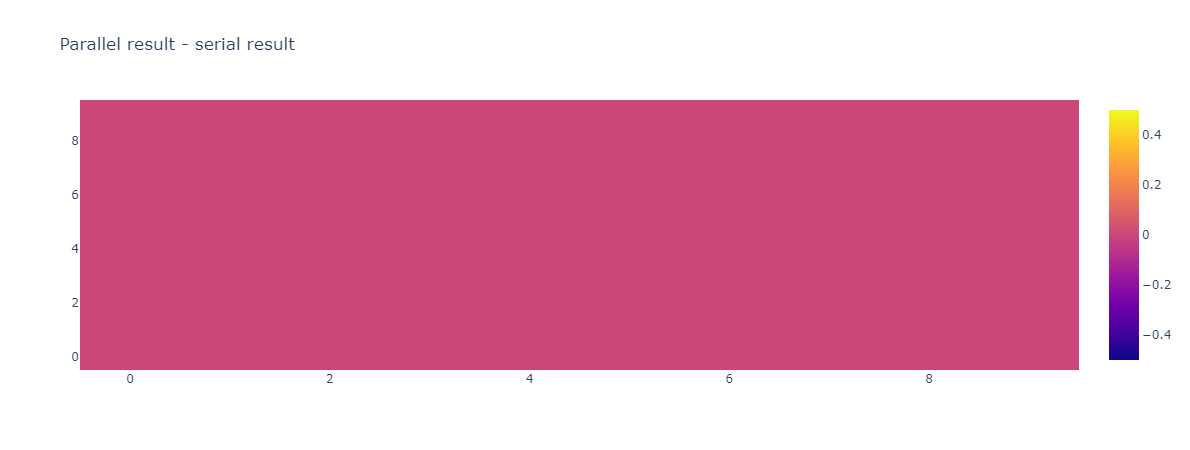

In [50]:
fig = go.Figure(data=go.Heatmap(
                    z=grid-grid_serial), 
                )
fig.layout.title = "Parallel result - serial result"
fig.show()

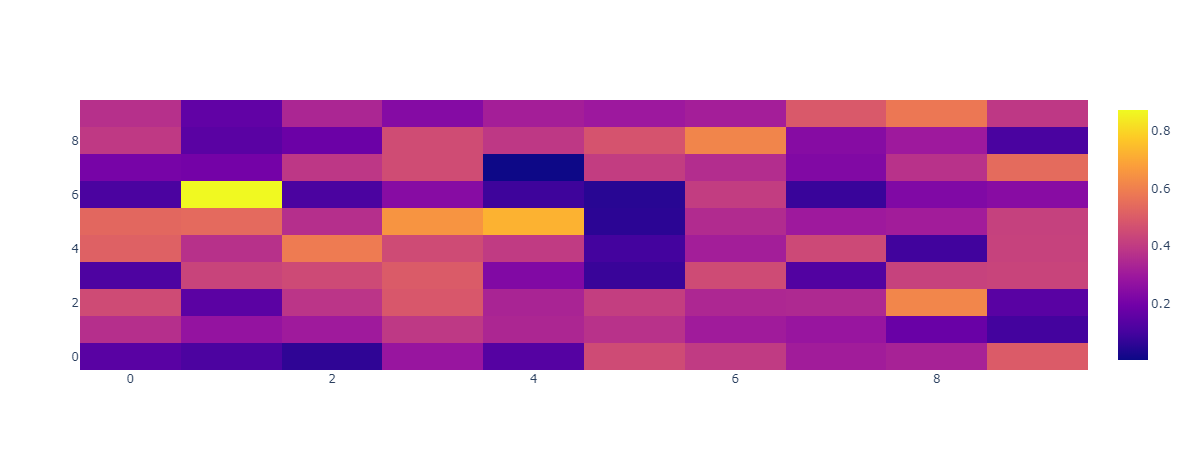

In [44]:
fig = go.Figure(data=go.Heatmap(
                    z=grid_transitions[:,:,0]))
fig.show()

In [2]:
any([1,2])

True

In [4]:
a = ["a", "b"]
list(enumerate(a, 12))

[(12, 'a'), (13, 'b')]